### Summary
Segmenting the test dataset

In [66]:
import numpy as np
import pandas as pd
import os
from os.path import join
import glob
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
import random

In [67]:
# 
TRAIN_PATH = 'data/stage1_train/'
TEST_PATH = 'data/stage1_test/'

In [68]:
# list of image ids
train_ids = os.listdir(TRAIN_PATH)
test_ids = os.listdir(TEST_PATH)

In [69]:
# list of image paths
# uses glob filename matching
test_image_paths = [glob.glob(join(TEST_PATH, test_id, "images", "*")) for test_id in test_ids]

In [72]:
random.seed(2)
tmp_image_path = np.random.choice(test_image_paths)
tmp_image_path

['data/stage1_test/0a849e0eb15faa8a6d7329c3dd66aabe9a294cccb52ed30a90c8ca99092ae732/images/0a849e0eb15faa8a6d7329c3dd66aabe9a294cccb52ed30a90c8ca99092ae732.png']

In [73]:
image = cv2.imread(tmp_image_path[0], cv2.IMREAD_GRAYSCALE)

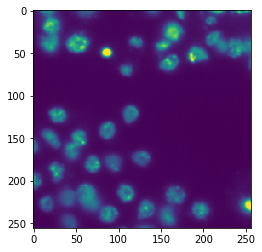

In [74]:
plt.imshow(image)

In [75]:
_, thresh = cv2.threshold(image, 100, 255, cv2.THRESH_OTSU)

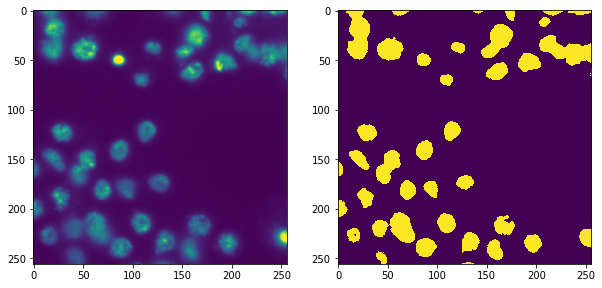

In [76]:
fig, axs = plt.subplots(1, 2, figsize=(10,10))
axs[0].imshow(image)
axs[1].imshow(thresh)

In [77]:
# resolution and size
image.shape, image.size

((256, 256), 65536)

In [78]:
image.min(), image.max()

(0, 255)

In [79]:
image.mean()

22.877670288085938

In [80]:
# Invert image if background is white and foreground is dark
_, cnts, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

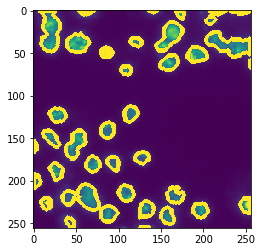

In [81]:
image1 = image.copy()
cv2.drawContours(image1, cnts,-1,(255,255,),3)
plt.imshow(image1)

In [82]:
max_cnt_area = cv2.contourArea(cnts[0])
print("The area of the largest object is: {0}".format(max_cnt_area))

The area of the largest object is: 821.0


In [83]:
# if the image is a white background and dark cells
# contour will be very large. If the contour area is large
# invert the image so that background is dark and foreground is white
if max_cnt_area > 50000:
    ret, thresh = cv2.threshold(tmp_image, 100, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)

In [84]:
# Remove any small holes in the object we use mor
mask = cv2.dilate(thresh, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5)))
mask = cv2.erode(mask, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5)))

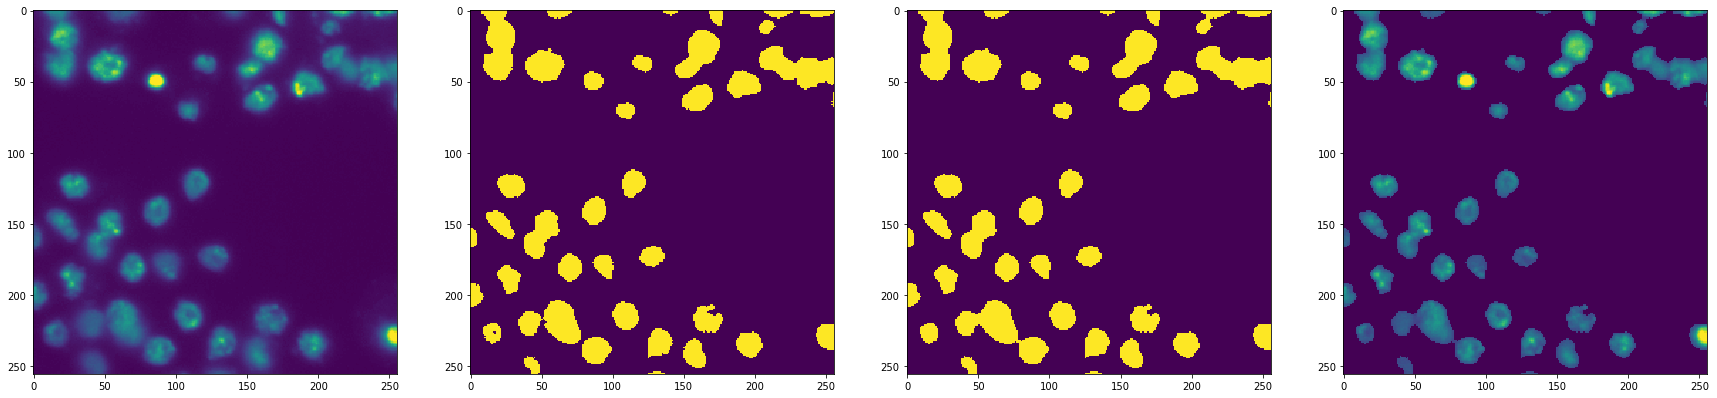

In [85]:
fig, axs = plt.subplots(1, 4, figsize=(30,30))
axs[0].imshow(image)
axs[1].imshow(thresh)
axs[2].imshow(mask)
axs[3].imshow(cv2.bitwise_and(image, image, mask=mask))

### Watershed
http://cmm.ensmp.fr/~beucher/wtshed.html

In [90]:
# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

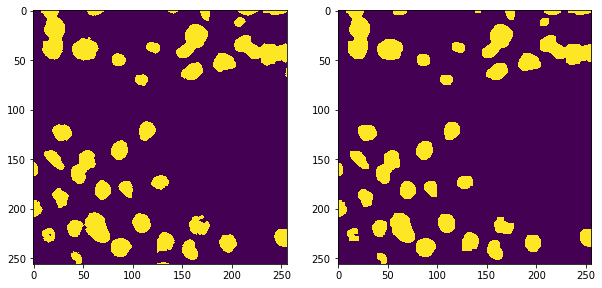

In [91]:
fig, axs = plt.subplots(1, 2, figsize=(10,10))
axs[0].imshow(thresh)
axs[1].imshow(opening)

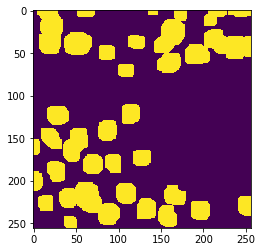

In [92]:
sure_bg = cv2.dilate(opening,kernel,iterations=3)
plt.imshow(sure_bg)

In [143]:
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.6*dist_transform.max(),255,0)

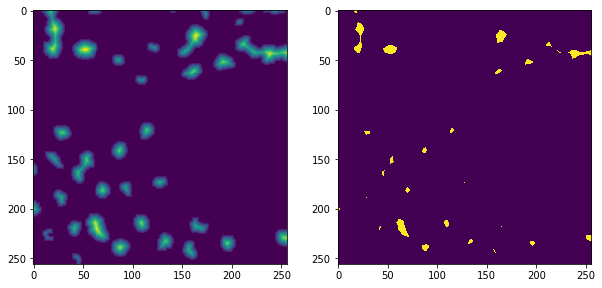

In [144]:
fig, axs = plt.subplots(1, 2, figsize=(10,10))
axs[0].imshow(dist_transform)
axs[1].imshow(sure_fg)

In [145]:
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

In [146]:
#create markers for watershed
_, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

# Now, mark the region of unknown with zero
markers[unknown==255] = 0
markers = markers.astype('int32')

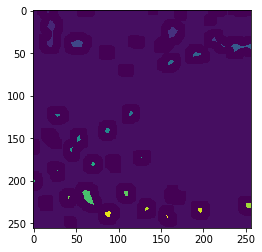

In [147]:
plt.imshow(markers)

In [148]:
image2 = cv2.imread(tmp_image_path[0], 1)
test = cv2.watershed(image2,markers)

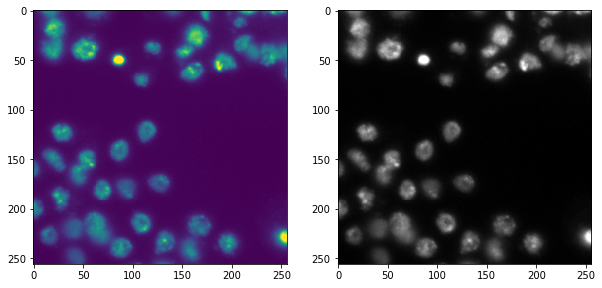

In [149]:
fig, axs = plt.subplots(1, 2, figsize=(10,10))
axs[0].imshow(image)
axs[1].imshow(image2)

In [150]:
image2[markers == -1] = [255,0,0]

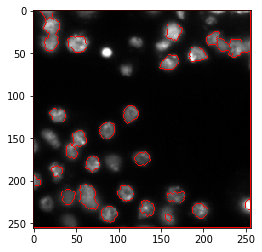

In [151]:
plt.imshow(image2)

### Test finding markers

In [154]:
import mahotas as mh


In [155]:
dnaf = mh.gaussian_filter(image, 8)
rmax = mh.regmax(dnaf)

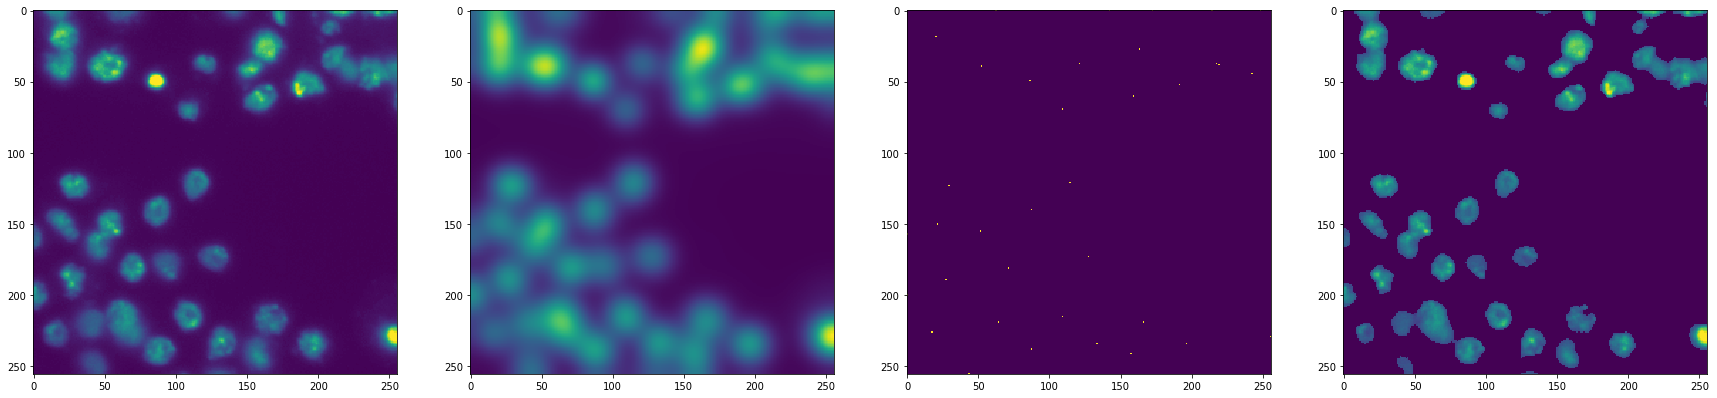

In [157]:
fig, axs = plt.subplots(1, 4, figsize=(30,30))
axs[0].imshow(image)
axs[1].imshow(dnaf)
axs[2].imshow(rmax)
axs[3].imshow(cv2.bitwise_and(image, image, mask=mask))

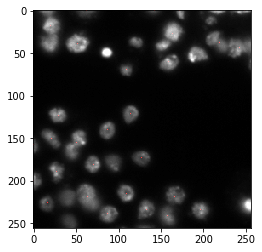

In [158]:
plt.imshow(mh.overlay(image,rmax))

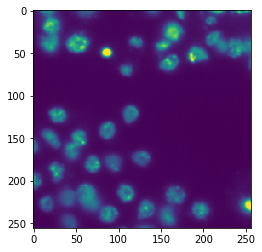

In [159]:
plt.imshow(image)

### Run Length Encoding (RLE)

### Resources
https://www.kaggle.com/gaborvecsei/basic-pure-computer-vision-segmentation-lb-0-229
http://cmm.ensmp.fr/~beucher/wtshed.html
http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_watershed/py_watershed.html